<a href="https://colab.research.google.com/github/kavyajeetbora/parrallel-computing-with-dask-datacamp/blob/main/part-1/working_with_big_data.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [76]:
import pandas as pd
import numpy as np
import psutil, os
from tqdm import tqdm
import seaborn as sns
import matplotlib.pyplot as plt
from zipfile import ZipFile

## 1. How big is dataframe

In [47]:
file = "/content/drive/MyDrive/Colab Notebooks/Data Science/Python Libraries/Dask/datacamp/data/dmi_climate_data.csv"
df = pd.read_csv(file)
df.head()

,time_observed,index,wind_speed,temp_dew,pressure,wind_dir,temp_dry,pressure_at_sea,temp_grass,wind_max,sun_last10min_glob,precip_past10min,radia_glob,temp_soil,leav_hum_dur_past10min,humidity,precip_dur_past10min,cloud_cover,visibility
0,2020-11-15 23:50:00,0.0,4.6,8.5,996.6,155.0,11.2,1001.5,10.4,9.3,0.0,NaN,0.0,9.5,0.0,NaN,0.0,90.0,45000.0
1,2020-11-16 00:00:00,1.0,4.2,8.6,996.5,158.0,11.3,1001.4,10.5,8.4,0.0,0.0,0.0,9.5,0.0,83.0,0.0,90.0,45000.0
2,2020-11-16 00:10:00,2.0,4.0,8.7,996.6,159.0,11.3,1001.5,10.4,7.4,0.0,0.0,0.0,9.4,0.0,84.0,0.0,90.0,35000.0
3,2020-11-16 00:20:00,3.0,3.9,8.8,996.6,161.0,11.2,1001.5,10.4,6.8,0.0,0.0,0.0,9.4,0.0,85.0,0.0,90.0,40000.0
4,2020-11-16 00:30:00,4.0,3.8,8.9,996.6,172.0,11.2,1001.6,10.3,9.6,0.0,0.0,0.0,9.4,7.0,86.0,0.0,90.0,25000.0


In [48]:
df.memory_usage()/1024 ## memory usage in KB

Index                       0.125000
time_observed             104.015625
index                     104.015625
wind_speed                104.015625
temp_dew                  104.015625
pressure                  104.015625
wind_dir                  104.015625
temp_dry                  104.015625
pressure_at_sea           104.015625
temp_grass                104.015625
wind_max                  104.015625
sun_last10min_glob        104.015625
precip_past10min          104.015625
radia_glob                104.015625
temp_soil                 104.015625
leav_hum_dur_past10min    104.015625
humidity                  104.015625
precip_dur_past10min      104.015625
cloud_cover               104.015625
visibility                104.015625
dtype: float64

In [49]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13314 entries, 0 to 13313
Data columns (total 19 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   time_observed           13314 non-null  object 
 1   index                   13314 non-null  float64
 2   wind_speed              13313 non-null  float64
 3   temp_dew                13313 non-null  float64
 4   pressure                13313 non-null  float64
 5   wind_dir                13313 non-null  float64
 6   temp_dry                13313 non-null  float64
 7   pressure_at_sea         13313 non-null  float64
 8   temp_grass              13312 non-null  float64
 9   wind_max                13312 non-null  float64
 10  sun_last10min_glob      13312 non-null  float64
 11  precip_past10min        13312 non-null  float64
 12  radia_glob              13312 non-null  float64
 13  temp_soil               13312 non-null  float64
 14  leav_hum_dur_past10min  13312 non-null

## 2. Memory footprint

Many NumPy transformations, while fast, use one or more temporary arrays. Therefore, those transformations require more storage than the original array required.

An array of temperature values in Celsius is provided for you as celsius. Your job is to monitor memory consumption while applying NumPy vectorized operations.



In [50]:
def memory_footprint():
    '''Returns memory (in MB) being used by Python process'''
    mem = psutil.Process(os.getpid()).memory_info().rss
    return (mem / 1024 ** 2)

In [51]:
before = memory_footprint()
N = (1024**2) // 8
x = np.random.randn(100*N)
print(x.nbytes/(1024**2),"MB")
after = memory_footprint()
print("Memory before: {:.2f} MB".format(before))
print("Memory usage: {:.2f} MB".format(after-before))

100.0 MB
Memory before: 2768.37 MB
Memory usage: 0.00 MB


In [52]:
before = memory_footprint()
x**2 ## computes but doesnot store it in a variable

array([0.13745627, 1.2514117 , 0.80625535, ..., 0.29581557, 0.81380228,
       0.94008321])

In [53]:
after = memory_footprint()
print("Extra memory obtained: {:.2f} MB".format(after-before))

Extra memory obtained: 0.00 MB


In [54]:
x.nbytes/(1024**2) ## in MB

100.0

We can also see the memory usage by converting it to a dataframe:

In [55]:
df = pd.DataFrame(x)

In [56]:
df.memory_usage(index=False) // (1024**2) ## memory footprint in MB

0    100
dtype: int64

We see there is extra memory acquired, even if the variable was not assigned

### Exercise on Numpy Transformation

Seeing how much extra memory is required for transforming a numpy array:

In [57]:
file = "/content/drive/MyDrive/Colab Notebooks/Data Science/Python Libraries/Dask/datacamp/data/dmi_climate_data.csv"
celsius = pd.read_csv(file)["temp_dry"]
print(celsius.shape)
celsius.head()

(13314,)


0    11.2
1    11.3
2    11.3
3    11.2
4    11.2
Name: temp_dry, dtype: float64

In [58]:
before = memory_footprint()
fahrenheit = celsius*9/5 + 32 ## numpy transformation
after = memory_footprint()

print("memory usage before: {:.2f} MB".format(before))
print("The memory usage by the new array is {:.2f} MB".format(fahrenheit.nbytes/(1024**2)))
print("The memory usage required for processing the changes: {:.2f} MB".format(after))

memory usage before: 2768.82 MB
The memory usage by the new array is 0.10 MB
The memory usage required for processing the changes: 2768.82 MB


## 3. Thinking about data in chunks

We've seen that available memory & storage restricts datasets that can be analyzed. A common strategy is to subdivide datasets into smaller parts / chunks

In [59]:
!wget https://s3.amazonaws.com/nyc-tlc/trip+data/yellow_tripdata_2013-01.csv

--2021-03-09 11:03:45--  https://s3.amazonaws.com/nyc-tlc/trip+data/yellow_tripdata_2013-01.csv
Resolving s3.amazonaws.com (s3.amazonaws.com)... 52.216.165.45
Connecting to s3.amazonaws.com (s3.amazonaws.com)|52.216.165.45|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2472351469 (2.3G) [application/octet-stream]
Saving to: ‘yellow_tripdata_2013-01.csv.1’

yellow_tripdata_201 100%[===================>]   2.30G  34.7MB/s    in 74s     

2021-03-09 11:05:00 (32.0 MB/s) - ‘yellow_tripdata_2013-01.csv.1’ saved [2472351469/2472351469]



In [60]:
%%time
filename = "/content/yellow_tripdata_2013-01.csv"
for chunk in pd.read_csv(filename, chunksize=50000):
    print("Type: %s | shape %s" %(type(chunk), chunk.shape))

Type: <class 'pandas.core.frame.DataFrame'> | shape (50000, 18)
Type: <class 'pandas.core.frame.DataFrame'> | shape (50000, 18)
Type: <class 'pandas.core.frame.DataFrame'> | shape (50000, 18)
Type: <class 'pandas.core.frame.DataFrame'> | shape (50000, 18)
Type: <class 'pandas.core.frame.DataFrame'> | shape (50000, 18)
Type: <class 'pandas.core.frame.DataFrame'> | shape (50000, 18)
Type: <class 'pandas.core.frame.DataFrame'> | shape (50000, 18)
Type: <class 'pandas.core.frame.DataFrame'> | shape (50000, 18)
Type: <class 'pandas.core.frame.DataFrame'> | shape (50000, 18)
Type: <class 'pandas.core.frame.DataFrame'> | shape (50000, 18)
Type: <class 'pandas.core.frame.DataFrame'> | shape (50000, 18)
Type: <class 'pandas.core.frame.DataFrame'> | shape (50000, 18)
Type: <class 'pandas.core.frame.DataFrame'> | shape (50000, 18)
Type: <class 'pandas.core.frame.DataFrame'> | shape (50000, 18)
Type: <class 'pandas.core.frame.DataFrame'> | shape (50000, 18)
Type: <class 'pandas.core.frame.DataFram

In [61]:
chunk.shape

(26615, 18)

In [62]:
chunk.head()

,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,trip_distance,pickup_longitude,pickup_latitude,rate_code,store_and_fwd_flag,dropoff_longitude,dropoff_latitude,payment_type,fare_amount,surcharge,mta_tax,tip_amount,tolls_amount,total_amount
14750000,CMT,2013-01-08 06:41:16,2013-01-08 06:48:12,1,2.2,-73.988912,40.748254,1,N,-73.961400,40.767962,CSH,9.0,0.0,0.5,0.0,0.0,9.5
14750001,CMT,2013-01-07 16:11:38,2013-01-07 16:29:28,1,2.7,-73.957860,40.768515,1,N,-73.983911,40.745913,CSH,13.5,1.0,0.5,0.0,0.0,15.0
14750002,CMT,2013-01-06 03:52:13,2013-01-06 03:57:53,1,1.2,-73.988092,40.722707,1,N,-73.976549,40.735186,CSH,6.0,0.5,0.5,0.0,0.0,7.0
14750003,CMT,2013-01-07 08:09:37,2013-01-07 08:12:02,1,0.6,-73.986484,40.755632,1,N,-73.990346,40.731513,CSH,4.0,0.0,0.5,0.0,0.0,4.5
14750004,CMT,2013-01-10 06:41:14,2013-01-10 06:45:29,1,0.7,-73.985062,40.768496,1,N,-73.980066,40.763805,CSH,5.0,0.0,0.5,0.0,0.0,5.5


### Filtering out long trips of more that 

In [63]:
is_expensive = (chunk.total_amount > 13)
chunk.loc[is_expensive].shape

(5887, 18)

Now we will appy this to the entire dataset:

In [64]:
def is_expensive_trip(data):
    """
    Returns a dataframe with trip cost more than 13 USD
    """
    is_expensive = (data.total_amount > 13)
    return data.loc[is_expensive]

applying it to all:


In [65]:
%%time
chunks = []
for chunk in tqdm(pd.read_csv(filename, chunksize=50000)):
    chunks.append(is_expensive_trip(chunk))

296it [00:41,  7.06it/s]

CPU times: user 40.6 s, sys: 1.78 s, total: 42.3 s
Wall time: 42.4 s


**The entire dataset was mever in the memory at one time**

In [66]:
chunk.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26615 entries, 14750000 to 14776614
Data columns (total 18 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   vendor_id           26615 non-null  object 
 1   pickup_datetime     26615 non-null  object 
 2   dropoff_datetime    26615 non-null  object 
 3   passenger_count     26615 non-null  int64  
 4   trip_distance       26615 non-null  float64
 5   pickup_longitude    26615 non-null  float64
 6   pickup_latitude     26615 non-null  float64
 7   rate_code           26615 non-null  int64  
 8   store_and_fwd_flag  25485 non-null  object 
 9   dropoff_longitude   26615 non-null  float64
 10  dropoff_latitude    26615 non-null  float64
 11  payment_type        26615 non-null  object 
 12  fare_amount         26615 non-null  float64
 13  surcharge           26615 non-null  float64
 14  mta_tax             26615 non-null  float64
 15  tip_amount          26615 non-null  float64

In [67]:
len(chunks)

296

In [68]:
expensive_trips_df = pd.concat(chunks)
expensive_trips_df.shape

(5059354, 18)

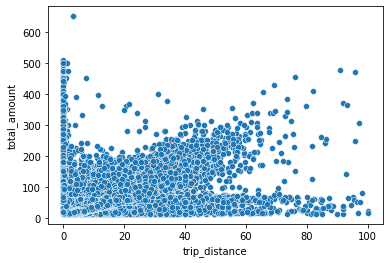

In [69]:
sns.scatterplot(x="trip_distance", y="total_amount", data=expensive_trips_df)
plt.show()

### Exercise: Filtering WDI data in chunks

**Task:** Using the World Bank's World Development Indicators (or WDI) dataset, you're going to plot the percentage of the population of Australia in urban centers since 1980.

Your job is to loop over chunks of the WDI dataset; from each chunk, you will filter out rows describing Australia's "percent urban population." You'll then concatenate the filtered chunks and plot the results. 

### Downloading the dataset from kaggle

**setting up kaggle datasets on colab**

[how to set up kaggle datasets on colab](https://towardsdatascience.com/downloading-kaggle-datasets-directly-into-google-colab-c8f0f407d73a)

In [72]:
!pip install -q kaggle

In [73]:
os.getcwd()

'/content'

In [74]:
os.environ["KAGGLE_CONFIG_DIR"] = "/content/drive/MyDrive/Colab Notebooks/Data Science/kaggle"

In [75]:
!kaggle datasets download -d worldbank/world-development-indicators

 98% 361M/369M [00:07<00:00, 37.4MB/s]
100% 369M/369M [00:07<00:00, 48.9MB/s]


In [78]:
%%time
with ZipFile("/content/world-development-indicators.zip", "r") as zfile:
    zfile.extractall()

## Analyzing the dataset

Since the dataset is huge, we will analyse it in chunks.

**Task**: Describe Australia's "percent urban population

In [89]:
%%time
dfs = []

for chunk in pd.read_csv("Indicators.csv", chunksize=5000):
    # IndicatorName Urban population (% of total)
    # CountryCode == AUS
    is_urban = (chunk["IndicatorName"]=="Urban population (% of total)")
    is_aus = (chunk["CountryCode"]=="AUS")
    filtered = chunk.loc[is_urban & is_aus]
    dfs.append(filtered)

In [90]:
len(dfs)

1132

In [94]:
df = pd.concat(dfs)
df

,CountryName,CountryCode,IndicatorName,IndicatorCode,Year,Value
4371,Australia,AUS,Urban population (% of total),SP.URB.TOTL.IN.ZS,1960,81.529
28235,Australia,AUS,Urban population (% of total),SP.URB.TOTL.IN.ZS,1961,81.941
55143,Australia,AUS,Urban population (% of total),SP.URB.TOTL.IN.ZS,1962,82.337
83535,Australia,AUS,Urban population (% of total),SP.URB.TOTL.IN.ZS,1963,82.727
112227,Australia,AUS,Urban population (% of total),SP.URB.TOTL.IN.ZS,1964,83.110
141761,Australia,AUS,Urban population (% of total),SP.URB.TOTL.IN.ZS,1965,83.485
173635,Australia,AUS,Urban population (% of total),SP.URB.TOTL.IN.ZS,1966,83.855
205222,Australia,AUS,Urban population (% of total),SP.URB.TOTL.IN.ZS,1967,84.217
237934,Australia,AUS,Urban population (% of total),SP.URB.TOTL.IN.ZS,1968,84.573
270629,Australia,AUS,Urban population (% of total),SP.URB.TOTL.IN.ZS,1969,84.922


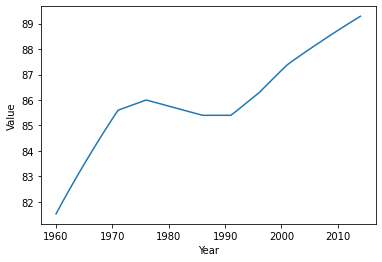

In [95]:
sns.lineplot(x="Year", y="Value", data=df)
plt.show()